# Climate Tutorial

In [1]:
import numpy as np
from scipy import constants as const
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

The climate model is contained within the `AdiabatClimate` class, which we import below.

In [2]:
# Climate model
from photochem.clima import AdiabatClimate

# Also set the thread count
from threadpoolctl import threadpool_limits
_ = threadpool_limits(limits=4)

## Initialization

The code is initialized with three files as shown below. Open each file, and check them out to get a sense for the information they contain.

In [3]:
c = AdiabatClimate(
    'input/species.yaml', # The species in the model + their thermodynamic properties
    'input/settings.yaml', # Planet settings + assumed optical properties
    'input/Sun_now.txt', # The stellar flux
)

Once initialized, the `AdiabatClimate` object contains all the information needed to do climate calculations.

In [4]:
print(c.species_names) # species in the model

['H2O', 'CO2', 'N2', 'H2', 'CH4', 'CO', 'O2']


## Constructing an atmosphere

Given the surface temperature and volatile inventories `AdiabatClimate` is able to draw a temperature profile and distribute gases in the atmosphere. One function that does this is `AdiabatClimate.make_profile`, which I illustrate below.

In [5]:
# The surface volatile inventories
P_i = np.ones(len(c.species_names))*1e-15
P_i[c.species_names.index('H2O')] = 270 # bar
P_i[c.species_names.index('N2')] = 1
P_i[c.species_names.index('CO2')] = 10
P_i *= 1e6 # Convert to dynes/cm^2

T_surf = 280 # surface temperature (K)
c.T_trop = 150 # tropopause temperature (K). 

# Integrates a multispecies pseudoadiabat upward following
# Equation (1) in Graham et al. 2021 (doi.org/10.3847/PSJ/ac214c)
c.make_profile(T_surf, P_i)

The object `c` now has attributes that describe the atmosphere
- `c.P`, pressures in atmospheric layers (dynes/cm$^2$)
- `c.P_surf` surface pressure (dynes/cm$^2$)
- `c.T`, temperature in atmospheric layers (K)
- `c.f_i`, mixing ratios of all species in atmospheric layers (2-D array)
- `c.z`, altitude of center of atmospheric layers (cm)
- `c.dz`, thickness of each atmospheric layers (cm)
- `c.N_atmos`, reservoir of each gas in the atmosphere (mol/cm$^2$)
- `c.N_surface`, reservoir of each gas on the surface (mol/cm$^2$)
- `c.N_ocean`, reservoir of each gas dissolved in oceans (mol/cm$^2$)

Here is an illustrative plot:

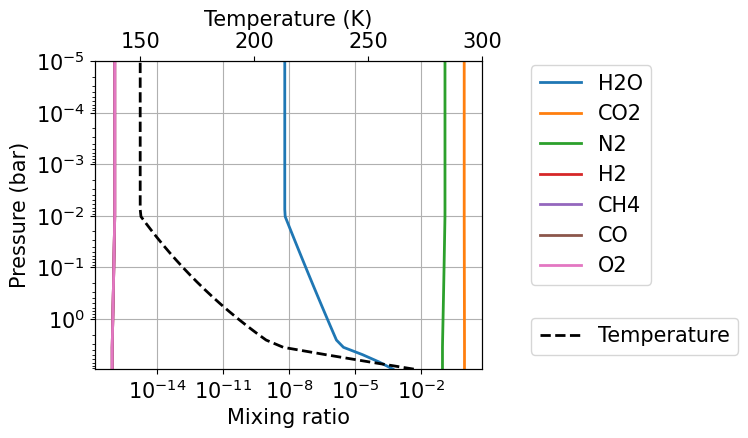

In [6]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i], c.P/1e6, lw=2, label=c.species_names[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(c.P[0]/1e6,1e-5)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.grid()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Mixing ratio')

ax1 = ax.twiny()

ax1.plot(c.T, c.P/1e6, 'k--', lw=2, label='Temperature')
ax1.set_xlabel('Temperature (K)')
ax1.legend(ncol=1,bbox_to_anchor=(1.1, .2), loc='upper left')
ax1.set_xlim(130,300)

plt.show()

In the figure above, the tropopause is at $10^{-2}$ bars. Below that, in the troposphere, the slope of the temperature profile changes at about 3 bars pressure. This is caused by the start of CO$_2$ condensation.

`c.N_atmos`, `c.N_surface` and `c.N_ocean` contains the reservoir of volatiles in mol/cm$^{2}$ in the atmosphere, surface, and dissolved in oceans. Only gases that are saturated at surface have a surface reservoir. In this case, only water has a surface reservoir, which can be thought of as an ocean. We have not included gas dissolution in oceans, so the model reports no dissolved gases. Later in this notebook we implement gas dissolution in oceans.  

In [7]:
print(c.N_atmos)

[4.42159276e-02 2.38640823e+02 2.42678579e+01 2.42678579e-14
 2.42678579e-14 2.42678579e-14 2.42678579e-14]


In [8]:
print(c.N_surface)

[15261.41777648     0.             0.             0.
     0.             0.             0.        ]


In [9]:
print(c.N_ocean)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


The surface pressure is about 11.01 bars from 10 bars of CO$_2$, 1 bar of N$_2$ and a little water vapor.

In [10]:
print(c.P_surf/1e6) # bars

11.010013835389945


The code contains two other routines for constructing atmosphere, which you can check out if you are interested:

- `AdiabatClimate.make_column` - Constructs an atmosphere given surface volatile reservoirs in moles/cm$^2$.
- `AdiabatClimate.make_profile_bg_gas` - Constructs an atmosphere where one molecule is treated as a background gas.


## Radiative transfer

Routines for constructing atmospheres have corresponding methods that both construct and atomsphere and subsequently compute that atmosphere's radiative properties. For example, the routine `AdiabatClimate.TOA_fluxes` calls `AdiabatClimate.make_profile`, then does solar and infrared radiative transfer, returning the fluxes at the top of the atmosphere.

In [11]:
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270 # bar
P_i[c.species_names.index('N2')] = 1
P_i[c.species_names.index('CO2')] = 400e-6
P_i *= 1e6 # Convert to dynes/cm^2

T_surf = 280
c.T_trop = 215

# Call TOA fluxes
ASR, OLR = c.TOA_fluxes(T_surf, P_i)
print(ASR) # mW/m^2
print(OLR) # mW/m^2

254458.5560996444
243820.38383020347


We can look at the emission of the planet as a function of wavelength.

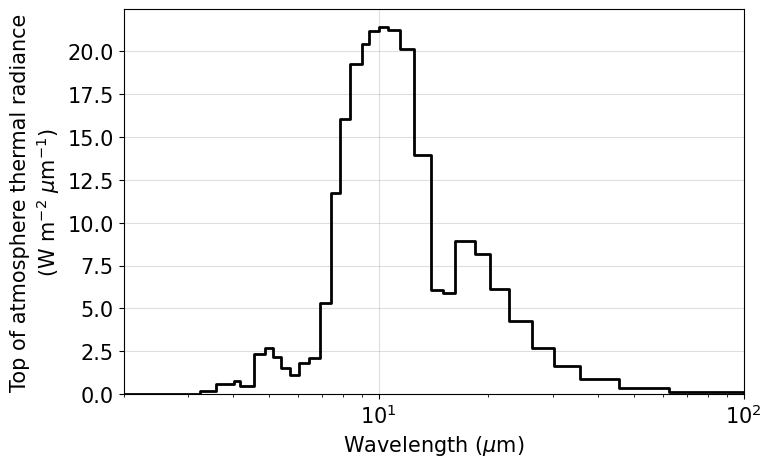

In [12]:
freq = c.rad.ir.freq # Hz
freq_av = (freq[1:]+freq[:-1])/2 # Hz
wv_av = 1e6*const.c/freq_av # microns
# c.rad.wrk_ir.fup_a is mW/m^2/Hz. Here I convert to W/m^2/um
F = 1e-3*c.rad.wrk_ir.fup_a[-1,:]*(freq_av/(wv_av))

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[8,5])

ax.plot(c.rad.ir.wavl[1:]/1e3, F, drawstyle='steps-pre',lw=2,c='k')

ax.set_xscale("log")
ax.set_xlim(2,100)
ax.set_ylim(0,ax.get_ylim()[1])
ax.grid(alpha=0.4)

ax.set_ylabel('Top of atmosphere thermal radiance\n'+r'(W m$^{-2}$ $\mu$m$^{-1}$)')
ax.set_xlabel(r'Wavelength ($\mu$m)')

plt.show()

## Steady-state climate modeling (approximate climates)

Up to this point we have merely constructed atmospheres and computed their radiative properties. In this section we calculate approximate steady-state climates, where we assume an adiabat connected to an isothermal stratosphere. To find steady states, we can use the `AdiabatClimate.surface_temperature` routine which numerically solves (via a variation of Newton's method) for the surface temperature which results in an atmosphere that balances incoming solar and outgoing long-wave radiation.

Below, we compute a steady-state climate for a generic habitable planet.

In [13]:
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270 # bar
P_i[c.species_names.index('N2')] = 1
P_i[c.species_names.index('CO2')] = 400e-6
P_i *= 1e6 # Convert to dynes/cm^2

c.P_top = 1e-4*1e6
c.T_trop = 215 # Have to set the stratosphere temp.
c.RH = np.ones(len(c.species_names))*0.5 # Change relative humidity to 0.5

# Call TOA fluxes
T_surf = c.surface_temperature(P_i, T_guess=280)
print(T_surf)

279.6045820650788


## Steady-state climate modeling (full radiative-convective equilibrium)

In the calculation above, we made climate a much easier problem by making assumptions about the temperature profile. Here, we use the `AdiabatClimate.RCE` routine to do the more challenging (and computationally expensive) problem of computing full radiative-convective equilibrium (RCE). The `AdiabatClimate.RCE` routine can often fail to converge if given a bad starting guess for the temperature profile.

In [14]:
P_i = np.ones(len(c.species_names))*1e-10
P_i[c.species_names.index('H2O')] = 270 # bar
P_i[c.species_names.index('N2')] = 1
P_i[c.species_names.index('CO2')] = 400e-6
P_i *= 1e6 # Convert to dynes/cm^2

c.P_top = 1e-4*1e6
c.max_rc_iters = 30
c.RH = np.ones(len(c.species_names))*0.5 # Change relative humidity to 0.5

# Get a starting guess for the temperature profile
T_surf = c.surface_temperature(P_i, T_guess=280)

# Solve for RCE with that starting guess 
converged = c.RCE(P_i, c.T_surf, c.T, c.convecting_with_below)
print(c.T_surf)

283.8038872896662


Below, we plot the temperature and composition profiles

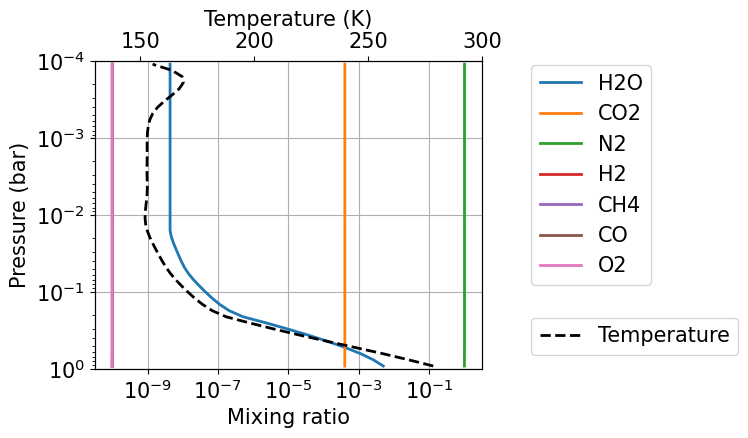

In [15]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i], c.P/1e6, lw=2, label=c.species_names[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(c.P_surf/1e6,1e-4)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.grid()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Mixing ratio')

ax1 = ax.twiny()

ax1.plot(c.T, c.P/1e6, 'k--', lw=2, label='Temperature')
ax1.set_xlabel('Temperature (K)')
ax1.legend(ncol=1,bbox_to_anchor=(1.1, .2), loc='upper left')
ax1.set_xlim(130,300)

plt.show()

Below, we show that at full RCE, the total radiative energy in the atmosphere is balanced except in places where there is convection.

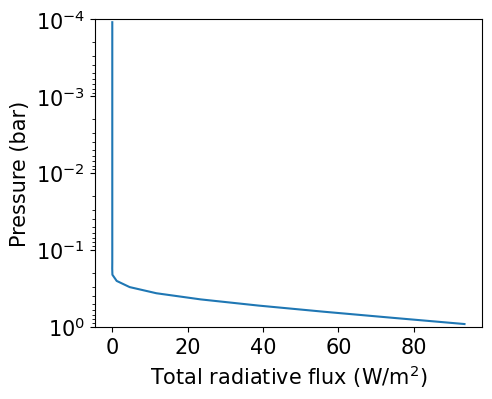

In [16]:
fig,ax = plt.subplots(1,1,figsize=[5,4])


f_total = (c.rad.wrk_sol.fdn_n[1:-1:2] - c.rad.wrk_sol.fup_n[1:-1:2]) + (c.rad.wrk_ir.fdn_n[1:-1:2] - c.rad.wrk_ir.fup_n[1:-1:2])
f_total *= 1e-3 # W/m^2

ax.plot(f_total, c.P/1e6)

ax.set_yscale('log')
ax.set_ylim(c.P_surf/1e6,1e-4)
ax.set_xlabel('Total radiative flux (W/m$^2$)')
ax.set_ylabel('Pressure (bar)')

plt.show()

## Utility functions

The function `AdiabatClimate.out2atmosphere_txt`, outputs the atmosphere to a file.

In [17]:
eddy = np.ones(len(c.T))*1e6 # Make an eddy diffusion profile
c.out2atmosphere_txt('atmosphere.txt', eddy=eddy, overwrite=True)

The output file can then be used by the photochemical model. Below is an example which does photochemistry on top of the P-T profile generated by the climate model.

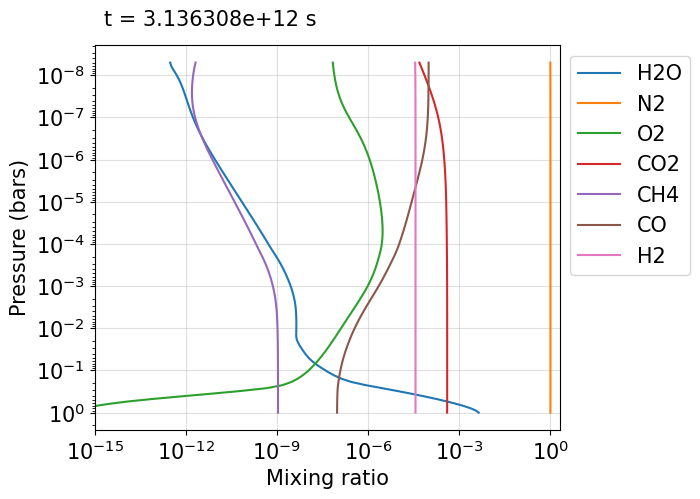

In [18]:
import yaml
import tempfile
from photochem import EvoAtmosphere, zahnle_earth

# Settings for for the photochemical model.
settings = yaml.safe_load("""
atmosphere-grid:
  bottom: 0.0
  top: atmospherefile
  number-of-layers: 100
planet:
  planet-mass: 5.972e27
  planet-radius: 6.371e8
  surface-albedo: 0.25
  solar-zenith-angle: 60.0
  hydrogen-escape: {type: diffusion limited}
  water: {fix-water-in-troposphere: false, gas-rainout: false, water-condensation: false}
particles:
- {name: H2Oaer, RH-condensation: 0.5}
boundary-conditions:
- name: N2
  lower-boundary: {type: vdep, vdep: 0.0}
  upper-boundary: {type: veff, veff: 0.0}
""")

# Initialize the photochemical model
with tempfile.NamedTemporaryFile('w') as f:
    yaml.dump(settings,f,yaml.Dumper)
    f.flush()
    pc = EvoAtmosphere(
        zahnle_earth,
        f.name,
        'input/Sun_now.txt',
        'atmosphere.txt'
    )

# Move the top of the atmosphere up to 1e-7 bar
pc.update_vertical_grid(TOA_pressure=1e-7*1e6)

# Add pressure boundary conditions for H2O, CO2 and N2
species = ['H2O','CO2','N2']
for i,sp in enumerate(species):
    pc.set_lower_bc(sp, bc_type='press', press=P_i[c.species_names.index(sp)])
pc.set_lower_bc('H2', bc_type='flux', flux=1e9) # volcanic flux of H2

# Find steady state
from utils import find_steady_state
find_steady_state(pc, xlim=(1e-15,2))

Also, you can print out the optical properties that are being used by the climate model

In [19]:
print(c.rad.opacities2yaml())

optical-properties:
  ir:
    k-method: RandomOverlapResortRebin
    opacities:
      k-distributions: [H2O, CO2, CH4, CO, O2]
      CIA: [H2O-H2O, H2O-N2, CO2-CO2, CO2-H2, CO2-CH4, N2-N2, N2-H2, N2-O2, H2-H2, H2-CH4, CH4-CH4, O2-O2]
      rayleigh: [N2, CO2, O2, H2O, H2]
  solar:
    k-method: RandomOverlapResortRebin
    opacities:
      k-distributions: [H2O, CO2, CH4, CO, O2]
      CIA: [H2O-H2O, H2O-N2, CO2-CO2, CO2-H2, CO2-CH4, N2-N2, N2-H2, N2-O2, H2-H2, H2-CH4, CH4-CH4, O2-O2]
      rayleigh: [N2, CO2, O2, H2O, H2]
